In [1]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt

from tensorflow import float32
from tensorflow.image import resize, rgb_to_grayscale, convert_image_dtype
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, CSVLogger

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from config import IMG_HEIGHT, IMG_WIDTH
from src.modules import data_loader
from src.face_recognition import ml_models


################## PATH ##################
DB_PATH = r"..\data\gui_database.db"
LFW_DATASET_PATH = r"..\data\dataset-lfw_reconstructed"
ML_OUTPUT = r"..\data\ml_models"
MODEL_SAVE_DIR = f'{ML_OUTPUT}/trained'
LOG_DIR = f'{ML_OUTPUT}/logs'


############# MODEL SETTINGS #############
#####--- prepare_data_train_model ---#####
INPUT_SHAPE = (100, 100, 1)
IMG_WIDTH, IMG_HEIGHT, CHANNELS = INPUT_SHAPE
SPLIT_STRATEGY = 'stratified'
TEST_SPLIT_RATIO = 0.2
VALIDATION_SPLIT_RATIO = 0.15
RANDOM_STATE = 42
N_TRAIN_PER_SUBJECT = 7
#####--- create_model ---#####
MODEL_NAME = 'simple_cnn_lfw_anony_v1'
MODEL_ARCHITECTURE = 'simple_cnn'
LEARNING_RATE = 0.001
EARLY_STOPPING_PATIENCE = 10
TRANSFER_BASE_MODEL_NAME = 'MobileNetV2'
TRANSFER_FREEZE_BASE = True
#####--- train_model ---#####
BATCH_SIZE = 32
EPOCHS = 50
##########################################

# Import Data

### Noised DB dataset

In [2]:
import controller.ml_controller as mlc

X, y, label_encoder = mlc.MLController.get_data_from_db(DB_PATH)
print(f"(nb_image, width, height, channels) : {X.shape}")

(nb_image, width, height, channels) : (467, 100, 100, 3)


### Noised LFW dataset

In [3]:
import controller.ml_controller as ml
os.makedirs(LFW_DATASET_PATH, exist_ok=True)

X, y, label_encoder = ml.data_loader.load_anonymized_images_flat(
    data_dir=LFW_DATASET_PATH,
    img_width=IMG_WIDTH,
    img_height=IMG_HEIGHT,
    color_mode='grayscale'
)

if not X.shape and not y.shape and not label_encoder:
    raise ValueError('Erreur critique lors du chargement des données. Arrêt du script.')
print(f"\n(nb_image, width, height, channels) : {X.shape}")

Chargement des images depuis : ..\data\dataset-lfw_reconstructed
Format attendu : 100x100, mode: grayscale
Trouvé 1240 fichiers PNG.
Chargement terminé. 1240 images traitées, 0 fichiers ignorés.
Shape final des données (X): (1240, 100, 100, 1)
1240 labels originaux encodés en 62 classes numériques.

(nb_image, width, height, channels) : (1240, 100, 100, 1)


# Train

In [4]:
##### prepare_data_train_model #####

# --- 2. Préparation des Données ---

def format_ml_image(image: np.array):
    # Convert to grayscale
    if image.ndim == 2:
        image = image[..., np.newaxis]
    elif image.shape[2] == 3:
        image = rgb_to_grayscale(image).numpy()
    elif image.shape[2] != 1:
        raise ValueError("Image must be grayscale or RGB.")
    # Resize & normalize image
    image = convert_image_dtype(image, dtype=float32)
    image = resize(image, [IMG_WIDTH, IMG_HEIGHT], method="area").numpy()
    return image

# Reshape images (size & channel=1)
processed_X = []
for img in X:
    img = format_ml_image(img)
    processed_X.append(img)
X = np.array(processed_X)

num_classes = len(label_encoder.classes_)
print(f"Nombre de classes détectées : {num_classes}")



# --- 3. Division des Données ---
print("\n--- Division des données ---")
X_train, y_train = None, None
X_val, y_val = None, None
X_test, y_test = None, None

if SPLIT_STRATEGY == 'stratified':
    data_splits = data_loader.split_data_stratified(
        X, y,
        test_size=TEST_SPLIT_RATIO,
        validation_size=VALIDATION_SPLIT_RATIO,
        random_state=RANDOM_STATE
    )
    X_train = data_splits.get('X_train')
    y_train = data_splits.get('y_train')
    X_val = data_splits.get('X_val')
    y_val = data_splits.get('y_val')
    X_test = data_splits.get('X_test')
    y_test = data_splits.get('y_test')

    if X_val is None and VALIDATION_SPLIT_RATIO > 0 and X_train is not None and len(X_train) > 0:
         val_ratio_from_train = VALIDATION_SPLIT_RATIO / (1.0 - TEST_SPLIT_RATIO)
         if val_ratio_from_train < 1.0:
             print(f"Création du set de validation depuis l'entraînement (ratio: {val_ratio_from_train:.2f})")
             X_train, X_val, y_train, y_val = train_test_split(
                 X_train, y_train,
                 test_size=val_ratio_from_train,
                 random_state=RANDOM_STATE,
                 stratify=y_train
             )
         else:
             print("Attention: Ratios de split incohérents, pas de données d'entraînement restantes après validation.")

elif SPLIT_STRATEGY == 'fixed_per_subject':
    X_train_full, X_test, y_train_full, y_test = data_loader.split_data_fixed_per_subject(
        X, y,
        n_train_per_class=N_TRAIN_PER_SUBJECT,
        random_state=RANDOM_STATE
    )
    if VALIDATION_SPLIT_RATIO > 0 and X_train_full is not None and len(X_train_full) > 0:
        print(f"Création du set de validation depuis l'entraînement (ratio: {VALIDATION_SPLIT_RATIO})")
        X_train, X_val, y_train, y_val = train_test_split(
            X_train_full, y_train_full,
            test_size=VALIDATION_SPLIT_RATIO,
            random_state=RANDOM_STATE,
            stratify=y_train_full
        )
    else:
        X_train, y_train = X_train_full, y_train_full
        X_val, y_val = None, None

else:
    print(f"Erreur: Stratégie de split '{SPLIT_STRATEGY}' non reconnue.")

if X_train is None or len(X_train) == 0:
    print("Erreur: Aucune donnée d'entraînement disponible après la division.")

if X_val is None or len(X_val) == 0:
    print("Attention: Aucune donnée de validation disponible. L'entraînement se fera sans suivi de validation.")
    validation_data = None # `fit` utilisera pas de validation
else:
    validation_data = (X_val, y_val)
    print(f"Taille finale - Entraînement: {len(X_train)}, Validation: {len(X_val)}, Test: {len(X_test) if X_test is not None else 0}")

Nombre de classes détectées : 62

--- Division des données ---
Division des données : test_size=0.2, validation_size=0.15
Taille Test: 248 échantillons
Taille Entraînement: 806 échantillons
Taille Validation: 186 échantillons
Taille finale - Entraînement: 806, Validation: 186, Test: 248


In [5]:
print("--- Démarrage du Script d'Entraînement ---")
start_time = time.time()

# --- 1. Chargement de la Configuration ---
print("Configuration chargée depuis config.py:")
print(f"  - Dossier Données: {LFW_DATASET_PATH}")
print(f"  - Dossier Sauvegarde Modèles: {MODEL_SAVE_DIR}")
print(f"  - Architecture Modèle: {MODEL_ARCHITECTURE}")
print(f"  - Nom Modèle: {MODEL_NAME}")
print(f"  - Dimensions Image: {INPUT_SHAPE}")
print(f"  - Stratégie Split: {SPLIT_STRATEGY}")
print(f"  - Époques: {EPOCHS}, Batch Size: {BATCH_SIZE}")

os.makedirs(MODEL_SAVE_DIR, exist_ok=True)
os.makedirs(LOG_DIR, exist_ok=True)
print(f"  - Dossier Logs TensorBoard: {LOG_DIR}")


--- Démarrage du Script d'Entraînement ---
Configuration chargée depuis config.py:
  - Dossier Données: ..\data\dataset-lfw_reconstructed
  - Dossier Sauvegarde Modèles: ..\data\ml_models/trained
  - Architecture Modèle: simple_cnn
  - Nom Modèle: simple_cnn_lfw_anony_v1
  - Dimensions Image: (100, 100, 1)
  - Stratégie Split: stratified
  - Époques: 50, Batch Size: 32
  - Dossier Logs TensorBoard: ..\data\ml_models/logs


In [6]:
# --- 4. Construction du Modèle ---
print("\n--- Construction du modèle ---")
model = None
if MODEL_ARCHITECTURE == 'simple_cnn':
    model = ml_models.build_simple_cnn(input_shape=INPUT_SHAPE, num_classes=num_classes)
elif MODEL_ARCHITECTURE.startswith('transfer_'):
    print(f"Utilisation du modèle de base: {TRANSFER_BASE_MODEL_NAME}, Freeze: {TRANSFER_FREEZE_BASE}")
    model = ml_models.build_transfer_model(input_shape=INPUT_SHAPE,
                                           num_classes=num_classes,
                                           base_model_name=TRANSFER_BASE_MODEL_NAME,
                                           freeze_base=TRANSFER_FREEZE_BASE)
else:
    print(f"Erreur: Architecture de modèle non reconnue dans config: {MODEL_ARCHITECTURE}")

if model is None:
    print("Erreur critique lors de la construction du modèle. Arrêt.")

# --- 5. Compilation du Modèle ---
print("\n--- Compilation du modèle ---")
optimizer = Adam(learning_rate=LEARNING_RATE)
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
print("Modèle compilé avec Adam optimizer.")
model.summary()


--- Construction du modèle ---
Construction du modèle CNN simple avec input_shape=(100, 100, 1) et num_classes=62
Modèle CNN simple construit.

--- Compilation du modèle ---
Modèle compilé avec Adam optimizer.


Model: "simple_cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 100, 100, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_1 (Conv2D)                │ (None, 100, 100, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn1_1 (BatchNormalization)      │ (None, 100, 100, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_2 (Conv2D)                │ (None, 100, 100, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn1_2 (BatchNormalization)      │ (None, 100, 100, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 50, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop1 (Dropout)                 │ (None, 50, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2_1 (Conv2D)                │ (None, 50, 50, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn2_1 (BatchNormalization)      │ (None, 50, 50, 64)     │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2_2 (Conv2D)                │ (None, 50, 50, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn2_2 (BatchNormalization)      │ (None, 50, 50, 64)     │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop2 (Dropout)                 │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 40000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 128)            │     5,120,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_dense1 (BatchNormalization)  │ (None, 128)            │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop_dense1 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_softmax (Dense)          │ (None, 62)             │         7,998 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,194,398 (19.82 MB)

 Trainable params: 5,193,758 (19.81 MB)

 Non-trainable params: 640 (2.50 KB)

In [7]:
# --- 6. Configuration des Callbacks ---
print("\n--- Configuration des Callbacks ---")
callbacks = []

model_filename = f"{MODEL_NAME}.h5"
model_filepath = os.path.join(MODEL_SAVE_DIR, model_filename)
print(f"  - ModelCheckpoint: Sauvegarde du meilleur modèle dans {model_filepath}")
checkpoint_callback = ModelCheckpoint(
    filepath=model_filepath,
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=False,
    mode='max',
    verbose=1
)
callbacks.append(checkpoint_callback)

if EARLY_STOPPING_PATIENCE and EARLY_STOPPING_PATIENCE > 0:
    print(f"  - EarlyStopping: Activé avec patience={EARLY_STOPPING_PATIENCE}")
    early_stopping_callback = EarlyStopping(
        monitor='val_accuracy',
        patience=EARLY_STOPPING_PATIENCE,
        mode='max',
        restore_best_weights=True,
        verbose=1
    )
    callbacks.append(early_stopping_callback)
else:
    print("  - EarlyStopping: Désactivé.")


if LOG_DIR and LOG_DIR:
    tensorboard_log_dir = os.path.join(LOG_DIR, MODEL_NAME + "_" + time.strftime("%Y%m%d-%H%M%S"))
    print(f"  - TensorBoard: Logs dans {tensorboard_log_dir}")
    tensorboard_callback = TensorBoard(
        log_dir=tensorboard_log_dir,
        histogram_freq=1
    )
    callbacks.append(tensorboard_callback)
else:
    print("  - TensorBoard: Désactivé.")

csv_log_path = os.path.join(MODEL_SAVE_DIR, f"{MODEL_NAME}_training_log.csv")
print(f"  - CSVLogger: Logs dans {csv_log_path}")
csv_logger_callback = CSVLogger(csv_log_path, append=False)
callbacks.append(csv_logger_callback)


--- Configuration des Callbacks ---
  - ModelCheckpoint: Sauvegarde du meilleur modèle dans ..\data\ml_models/trained\simple_cnn_lfw_anony_v1.h5
  - EarlyStopping: Activé avec patience=10
  - TensorBoard: Logs dans ..\data\ml_models/logs\simple_cnn_lfw_anony_v1_20250427-193406
  - CSVLogger: Logs dans ..\data\ml_models/trained\simple_cnn_lfw_anony_v1_training_log.csv


In [8]:
# --- 7. Entraînement du Modèle ---
print("\n--- Démarrage de l'entraînement ---")
history = None
try:
    history = model.fit(
        X_train, y_train,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_data=validation_data,
        callbacks=callbacks,
        verbose=1
    )
    print("--- Entraînement terminé ---")

except Exception as e:
    print(f"\nErreur pendant l'entraînement : {e}")
    encoder_save_path = os.path.join(MODEL_SAVE_DIR, f"{MODEL_NAME}_label_encoder.joblib")
    print("\nSauvegarde de l'encodeur de labels (même si l'entraînement a échoué)...")
    data_loader.save_label_encoder(label_encoder, encoder_save_path)


--- Démarrage de l'entraînement ---
Epoch 1/50
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.0764 - loss: 4.4878
Epoch 1: val_accuracy improved from -inf to 0.02688, saving model to ..\data\ml_models/trained\simple_cnn_lfw_anony_v1.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 201ms/step - accuracy: 0.0814 - loss: 4.4520 - val_accuracy: 0.0269 - val_loss: 4.5797
Epoch 2/50
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.5449 - loss: 2.2355
Epoch 2: val_accuracy did not improve from 0.02688
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 175ms/step - accuracy: 0.5480 - loss: 2.2224 - val_accuracy: 0.0161 - val_loss: 4.4068
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.8707 - loss: 1.0612
Epoch 3: val_accuracy did not improve from 0.02688
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 179ms/step - accuracy: 0.8711 - loss: 1.0582 - val_accuracy: 0.0108 - val_loss: 4.4875
Epoch 4/50
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - accuracy: 0.9812 - loss: 0.5241
Epoch 4: val_accuracy did not improve from 0.02688
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 185ms/step - accuracy: 0.9813 - loss: 0.5206 - val_accuracy: 0.0161 - val_loss: 4.5380
Epoch 5/50
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - accuracy: 0.9972 - loss: 0.3052
Epoch 5: val_accuracy improved from

26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 191ms/step - accuracy: 0.9969 - loss: 0.3052 - val_accuracy: 0.0323 - val_loss: 5.1260
Epoch 6/50
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - accuracy: 0.9979 - loss: 0.2133
Epoch 6: val_accuracy did not improve from 0.03226
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 190ms/step - accuracy: 0.9978 - loss: 0.2126 - val_accuracy: 0.0269 - val_loss: 6.0595
Epoch 7/50
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.9988 - loss: 0.1861
Epoch 7: val_accuracy did not improve from 0.03226
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 205ms/step - accuracy: 0.9988 - loss: 0.1842 - val_accuracy: 0.0215 - val_loss: 6.3640
Epoch 8/50
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 1.0000 - loss: 0.1111
Epoch 8: val_accuracy did not improve from 0.03226
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 189ms/step - accuracy: 1.0000 - loss: 0.1110 - val_accuracy: 0.0269 - val_loss: 8.8663
Epoch 9/50
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - accuracy: 0.9981 - loss: 0.1055
Epoch 9: val_accuracy did not impro

26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 187ms/step - accuracy: 1.0000 - loss: 0.0775 - val_accuracy: 0.0376 - val_loss: 10.2450
Epoch 11/50
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 1.0000 - loss: 0.0654
Epoch 11: val_accuracy improved from 0.03763 to 0.05376, saving model to ..\data\ml_models/trained\simple_cnn_lfw_anony_v1.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 187ms/step - accuracy: 1.0000 - loss: 0.0654 - val_accuracy: 0.0538 - val_loss: 10.1803
Epoch 12/50
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 1.0000 - loss: 0.0575
Epoch 12: val_accuracy improved from 0.05376 to 0.08602, saving model to ..\data\ml_models/trained\simple_cnn_lfw_anony_v1.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 189ms/step - accuracy: 1.0000 - loss: 0.0577 - val_accuracy: 0.0860 - val_loss: 9.9752
Epoch 13/50
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 1.0000 - loss: 0.0483
Epoch 13: val_accuracy improved from 0.08602 to 0.16129, saving model to ..\data\ml_models/trained\simple_cnn_lfw_anony_v1.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 187ms/step - accuracy: 1.0000 - loss: 0.0484 - val_accuracy: 0.1613 - val_loss: 8.7037
Epoch 14/50
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 1.0000 - loss: 0.0427
Epoch 14: val_accuracy improved from 0.16129 to 0.23118, saving model to ..\data\ml_models/trained\simple_cnn_lfw_anony_v1.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 187ms/step - accuracy: 1.0000 - loss: 0.0429 - val_accuracy: 0.2312 - val_loss: 8.4976
Epoch 15/50
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 1.0000 - loss: 0.0429
Epoch 15: val_accuracy improved from 0.23118 to 0.41398, saving model to ..\data\ml_models/trained\simple_cnn_lfw_anony_v1.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 186ms/step - accuracy: 1.0000 - loss: 0.0431 - val_accuracy: 0.4140 - val_loss: 5.5171
Epoch 16/50
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 1.0000 - loss: 0.0353
Epoch 16: val_accuracy improved from 0.41398 to 0.63978, saving model to ..\data\ml_models/trained\simple_cnn_lfw_anony_v1.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 186ms/step - accuracy: 1.0000 - loss: 0.0352 - val_accuracy: 0.6398 - val_loss: 2.9117
Epoch 17/50
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - accuracy: 1.0000 - loss: 0.0294
Epoch 17: val_accuracy improved from 0.63978 to 0.76344, saving model to ..\data\ml_models/trained\simple_cnn_lfw_anony_v1.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 189ms/step - accuracy: 1.0000 - loss: 0.0294 - val_accuracy: 0.7634 - val_loss: 1.9495
Epoch 18/50
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - accuracy: 1.0000 - loss: 0.0286
Epoch 18: val_accuracy improved from 0.76344 to 0.90323, saving model to ..\data\ml_models/trained\simple_cnn_lfw_anony_v1.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 190ms/step - accuracy: 1.0000 - loss: 0.0284 - val_accuracy: 0.9032 - val_loss: 0.8680
Epoch 19/50
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - accuracy: 1.0000 - loss: 0.0291
Epoch 19: val_accuracy improved from 0.90323 to 0.90860, saving model to ..\data\ml_models/trained\simple_cnn_lfw_anony_v1.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 191ms/step - accuracy: 1.0000 - loss: 0.0290 - val_accuracy: 0.9086 - val_loss: 0.6806
Epoch 20/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 1.0000 - loss: 0.0263
Epoch 20: val_accuracy improved from 0.90860 to 0.97312, saving model to ..\data\ml_models/trained\simple_cnn_lfw_anony_v1.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 189ms/step - accuracy: 1.0000 - loss: 0.0264 - val_accuracy: 0.9731 - val_loss: 0.3781
Epoch 21/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - accuracy: 1.0000 - loss: 0.0285
Epoch 21: val_accuracy improved from 0.97312 to 0.98387, saving model to ..\data\ml_models/trained\simple_cnn_lfw_anony_v1.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 218ms/step - accuracy: 1.0000 - loss: 0.0287 - val_accuracy: 0.9839 - val_loss: 0.3407
Epoch 22/50
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 1.0000 - loss: 0.0225
Epoch 22: val_accuracy did not improve from 0.98387
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 204ms/step - accuracy: 1.0000 - loss: 0.0227 - val_accuracy: 0.9839 - val_loss: 0.2369
Epoch 23/50
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 1.0000 - loss: 0.0276
Epoch 23: val_accuracy did not improve from 0.98387
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 188ms/step - accuracy: 1.0000 - loss: 0.0276 - val_accuracy: 0.9839 - val_loss: 0.1594
Epoch 24/50
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - accuracy: 1.0000 - loss: 0.0237
Epoch 24: val_accuracy did not improve from 0.98387
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 188ms/step - accuracy: 1.0000 - loss: 0.0236 - val_accuracy: 0.9839 - val_loss: 0.1333
Epoch 25/50
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - accuracy: 1.0000 - loss: 0.0172
Epoch 25: val_accuracy impro

26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 192ms/step - accuracy: 1.0000 - loss: 0.0172 - val_accuracy: 0.9946 - val_loss: 0.1106
Epoch 26/50
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 1.0000 - loss: 0.0198
Epoch 26: val_accuracy did not improve from 0.99462
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 183ms/step - accuracy: 1.0000 - loss: 0.0197 - val_accuracy: 0.9892 - val_loss: 0.1191
Epoch 27/50
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 1.0000 - loss: 0.0162
Epoch 27: val_accuracy did not improve from 0.99462
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 185ms/step - accuracy: 1.0000 - loss: 0.0163 - val_accuracy: 0.9946 - val_loss: 0.1112
Epoch 28/50
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 1.0000 - loss: 0.0161
Epoch 28: val_accuracy did not improve from 0.99462
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 183ms/step - accuracy: 1.0000 - loss: 0.0161 - val_accuracy: 0.9892 - val_loss: 0.1050
Epoch 29/50
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - accuracy: 1.0000 - loss: 0.0170
Epoch 29: val_accuracy did n


--- Sauvegarde de l'encodeur de labels ---
LabelEncoder sauvegardé dans : ..\data\ml_models/trained\simple_cnn_lfw_anony_v1_label_encoder.joblib

--- Affichage des courbes d'apprentissage ---
Courbes sauvegardées dans : ..\data\ml_models/trained\simple_cnn_lfw_anony_v1_training_curves.pdf

--- Script d'Entraînement Terminé en 177.03 secondes ---
Le meilleur modèle devrait être sauvegardé dans : ..\data\ml_models/trained\simple_cnn_lfw_anony_v1.h5
L'encodeur de labels est sauvegardé dans : ..\data\ml_models/trained\simple_cnn_lfw_anony_v1_label_encoder.joblib


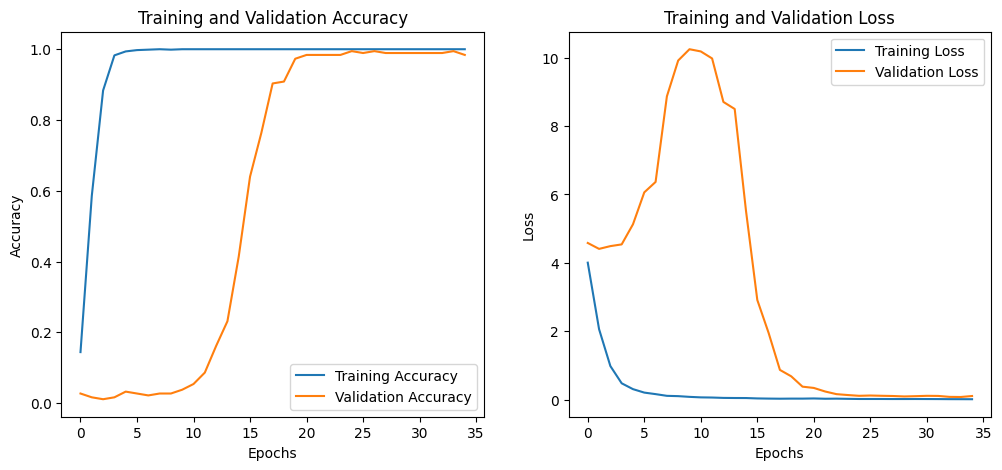

In [9]:
# --- 8. Post-Entraînement ---
encoder_save_path = os.path.join(MODEL_SAVE_DIR, f"{MODEL_NAME}_label_encoder.joblib")
print("\n--- Sauvegarde de l'encodeur de labels ---")
data_loader.save_label_encoder(label_encoder, encoder_save_path)

if history is not None:
    print("\n--- Affichage des courbes d'apprentissage ---")
    try:
        acc = history.history['accuracy']
        loss = history.history['loss']
        epochs_range = range(len(acc))

        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.plot(epochs_range, acc, label='Training Accuracy')
        if validation_data: # Seulement si validation existe
             val_acc = history.history['val_accuracy']
             plt.plot(epochs_range, val_acc, label='Validation Accuracy')
        plt.legend(loc='lower right')
        plt.title('Training and Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')

        plt.subplot(1, 2, 2)
        plt.plot(epochs_range, loss, label='Training Loss')
        if validation_data: # Seulement si validation existe
            val_loss = history.history['val_loss']
            plt.plot(epochs_range, val_loss, label='Validation Loss')
        plt.legend(loc='upper right')
        plt.title('Training and Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')

        plot_save_path = os.path.join(MODEL_SAVE_DIR, f"{MODEL_NAME}_training_curves.pdf")
        plt.savefig(plot_save_path, format='pdf', bbox_inches='tight')
        print(f"Courbes sauvegardées dans : {plot_save_path}")

    except Exception as plot_e:
        print(f"Erreur lors de la génération/sauvegarde des courbes: {plot_e}")


end_time = time.time()
duration = end_time - start_time
print(f"\n--- Script d'Entraînement Terminé en {duration:.2f} secondes ---")
print(f"Le meilleur modèle devrait être sauvegardé dans : {model_filepath}")
print(f"L'encodeur de labels est sauvegardé dans : {encoder_save_path}")

In [10]:
# Evaluation
eval_loss, eval_acc = model.evaluate(X_test, y_test)
y_pred = np.argmax(model.predict(X_test), axis=1)
cm = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)
print(f"Evaluation Loss: {eval_loss:.4f}")
print(f"Evaluation Accuracy: {eval_acc*100:.2f}%")
print(report)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9889 - loss: 0.1282
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
Evaluation Loss: 0.1179
Evaluation Accuracy: 99.19%
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         4
           3       1.00      0.75      0.86         4
           4       1.00      1.00      1.00         4
           5       1.00      1.00      1.00         4
           6       0.80      1.00      0.89         4
           7       1.00      1.00      1.00         4
           8       1.00      1.00      1.00         4
           9       1.00      1.00      1.00         4
          10       1.00      1.00      1.00         4
          11       1.00      1.00      1.00         4
          12       1.00      1.00      1.00         4
          13       1.00      1.00      1.00         4
          14       1.00    

# Predict noised image

In [11]:
import os
import numpy as np
import time
from typing import Optional
from PIL import Image

user = 9
image_path = f"../data/dataset-lfw_reconstructed/reconstructed_{user}_2.png"

In [12]:
print("--- Démarrage du Script de Prédiction ---")
start_time = time.time()

# --- 1. Charger Configuration et Chemins ---
print("Chargement de la configuration...")
model_filename = f"{MODEL_NAME}.h5" # ou .keras
model_filepath = os.path.join(MODEL_SAVE_DIR, model_filename)
encoder_filename = f"{MODEL_NAME}_label_encoder.joblib"
encoder_filepath = os.path.join(MODEL_SAVE_DIR, encoder_filename)

print(f"  - Modèle utilisé: {model_filepath}")
print(f"  - Encodeur utilisé: {encoder_filepath}")
print(f"  - Image à prédire: {image_path}")

--- Démarrage du Script de Prédiction ---
Chargement de la configuration...
  - Modèle utilisé: ..\data\ml_models/trained\simple_cnn_lfw_anony_v1.h5
  - Encodeur utilisé: ..\data\ml_models/trained\simple_cnn_lfw_anony_v1_label_encoder.joblib
  - Image à prédire: ../data/dataset-lfw_reconstructed/reconstructed_9_2.png


In [13]:
# --- 2. Charger Modèle et Encodeur ---
print("\n--- Chargement du modèle et de l'encodeur ---")
if not os.path.exists(model_filepath):
    print(f"Erreur: Fichier modèle non trouvé: {model_filepath}")
try:
    model = load_model(model_filepath)
    print("Modèle chargé avec succès.")
except Exception as e:
    print(f"Erreur lors du chargement du modèle Keras: {e}")

# Charger l'encodeur de labels
label_encoder = data_loader.load_label_encoder(encoder_filepath)
if label_encoder is None:
    print("Erreur critique : Impossible de charger l'encodeur de labels.")


--- Chargement du modèle et de l'encodeur ---
Modèle chargé avec succès.
LabelEncoder chargé depuis : ..\data\ml_models/trained\simple_cnn_lfw_anony_v1_label_encoder.joblib


In [14]:
# --- 3. Prétraiter l'Image d'Entrée ---

def preprocess_single_image(
    image_path: str,
    img_width: int,
    img_height: int,
) -> Optional[np.ndarray]:
    """
    Charge, redimensionne, normalise et formate une image unique pour la prédiction.
    """
    try:
        image = Image.open(image_path)
        image = np.array(image)
        image = format_ml_image(image)
        image = np.expand_dims(image, axis=-1)
        image = np.expand_dims(image, axis=0)
        print(f"Image prétraitée, shape final: {image.shape}")
        return image

    except FileNotFoundError:
        print(f"Erreur: Fichier image introuvable : {image_path}")
        return None
    except Exception as e:
        print(f"Erreur lors du prétraitement de l'image {image_path}: {e}")
        return None

print("\n--- Prétraitement de l'image d'entrée ---")
preprocessed_image = preprocess_single_image(
    image_path=image_path,
    img_width=IMG_WIDTH,
    img_height=IMG_HEIGHT,
)

if preprocessed_image is None:
    print("Échec du prétraitement de l'image.")


--- Prétraitement de l'image d'entrée ---
Image prétraitée, shape final: (1, 100, 100, 1, 1)


In [15]:
# --- 4. Faire la Prédiction ---
print("\n--- Prédiction ---")
try:
    prediction_probabilities = model.predict(preprocessed_image)

    predicted_index = np.argmax(prediction_probabilities[0])
    prediction_confidence = prediction_probabilities[0][predicted_index]

    predicted_label = label_encoder.inverse_transform([predicted_index])[0]

    print("\n--- Résultat de la Prédiction ---")
    print(f"  - Image : {os.path.basename(image_path)}")
    print(f"  - Identité Prédite (Subject ID) : {predicted_label}")
    print(f"  - Confiance : {prediction_confidence:.4f} ({prediction_confidence*100:.2f}%)")

except Exception as e:
    print(f"Erreur lors de la prédiction: {e}")

end_time = time.time()
duration = end_time - start_time
print(f"\n--- Script de Prédiction Terminé en {duration:.2f} secondes ---")

print(predicted_label)


--- Prédiction ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step

D:\myDocs\Apprentissage\Isep\Year_3\Brno-Privacy_Preserving_Face_Recognition_Project\venv\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_image']
Received: inputs=Tensor(shape=(1, 100, 100, 1, 1))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step

--- Résultat de la Prédiction ---
  - Image : reconstructed_9_2.png
  - Identité Prédite (Subject ID) : 9
  - Confiance : 0.9963 (99.63%)

--- Script de Prédiction Terminé en 0.29 secondes ---
9
